<a href="https://colab.research.google.com/github/ccg-esb/MI/blob/main/MI_2_RegulatoryModel_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook focuses on incorporating experimental data to parameterize the transcriptional and translational regulatory model developed in the first notebook. Using fluorescence, fitness, and recombination datasets, it extracts parameters like gene-specific translation scaling constants. The notebook employs optimization routines to match model predictions with experimental data, providing refined values for critical parameters. These parameterized models form the basis for evaluating the regulatory dynamics of various gene arrangements.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from itertools import permutations
from scipy.integrate import odeint
from itertools import product
import pandas as pd
import gspread
from gspread_dataframe import get_as_dataframe
from google.colab import auth
from google.auth import default
import pickle
from google.colab import drive
import os

In [ ]:

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Define the base path in Google Drive and a subdirectory for parameters
base_path = '/content/drive/My Drive/SYNC_Projects/MI/'  #
pathPARAMS = os.path.join(base_path, 'data/')


Mounted at /content/drive


In [ ]:

k_GFP=0.4
num_genes = 5

alpha = [0.5] * num_genes   # Transcription rates (mRNA molecules per minute, moderate promoter strength)
beta = [1.8] * num_genes    # Translation rates (proteins per mRNA per minute)
delta = [0.6] * num_genes  # Protein degradation rates (moderately stable proteins)
d_base = [0.5] * num_genes  # Baseline mRNA degradation rates (short mRNA half-lives)

k_values = [0.6] * num_genes  # Gene-specific scaling constants for the translation effect


#T_initial = [10.0] * num_genes  # Initial translation rates
m_initial = [0.01] * num_genes  # Initial mRNA concentrations
p_initial = [0.0] * num_genes  # Initial protein concentrations
t = np.linspace(0, 100, 100)  # Time array

In [ ]:

from scipy.integrate import odeint
import numpy as np

def runODE(num_genes, alpha, beta, delta, d_base, k_values, m_initial, p_initial, t):
    """
    Simulates the ODEs for mRNA and protein dynamics for a given number of genes, each with its own k value.

    Parameters:
        num_genes (int): Number of genes in the system.
        alpha (list): Transcription rates for each gene.
        beta (list): Translation rates for each gene.
        delta (list): Protein degradation rates for each gene.
        d_base (list): Baseline mRNA degradation rates for each gene.
        k_values (list): Scaling constants for the translation effect for each gene.
        m_initial (list): Initial mRNA concentrations for each gene.
        p_initial (list): Initial protein concentrations for each gene.
        t (array): Time array for simulation.

    Returns:
        sol (array): Solution array with mRNA and protein concentrations over time.
    """
    def model(y, t, alpha, beta, delta, d_base, k_values, num_genes):
        # Split y into mRNA and protein concentrations
        m = y[:num_genes]
        p = y[num_genes:]

        # Derivatives
        dm_dt = np.zeros(num_genes)
        dp_dt = np.zeros(num_genes)

        # Calculate translation rates based on current mRNA concentrations
        T = beta * m  # Translation rate is proportional to mRNA concentration

        for i in range(num_genes):
            if i == 0:
                # No upstream protection for the first gene
                degradation_rate = d_base[i]
            else:
                # For subsequent genes, apply upstream protection effect
                upstream_translation = T[i-1]
                degradation_rate = d_base[i] / (k_values[i-1] * upstream_translation)
                #print(k_values[i-1], d_base[i], degradation_rate)

            # ODE for mRNA concentration
            dm_dt[i] = alpha[i] - degradation_rate * m[i]

            # ODE for protein concentration using T[i]
            dp_dt[i] = T[i] - delta[i] * p[i]

        return np.concatenate([dm_dt, dp_dt])

    # Initial conditions
    y0 = np.concatenate([m_initial, p_initial])

    # Solve ODEs
    sol = odeint(model, y0, t, args=(alpha, beta, delta, d_base, k_values, num_genes))

    return sol


    # Initial conditions
    y0 = np.concatenate([m_initial, p_initial])

    # Solve ODEs
    sol = odeint(model, y0, t, args=(alpha, beta, delta, d_base, k_values, num_genes))

    return sol


In [ ]:

# Function to run the experiment for a given permutation of genes
def run_experiment(gene_order, k_values):
    # Adjust k_values to match the length of gene_order
    reordered_k_values = [k_values[gene_order[i]] for i in range(len(gene_order))]
    while len(reordered_k_values) < num_genes:
        reordered_k_values.append(k_values[2])  # Fill with the k value of gene 3 if fewer genes are present
    sol = runODE(num_genes, alpha, beta, delta, d_base, reordered_k_values,  m_initial, p_initial, t)
    focal_gene_index = gene_order.index(2)  # Find the index where the 3rd cassette (Gene 3) is
    return sol[-1, num_genes + focal_gene_index]

# Function to run the experiment for a given combination of genes, focusing on the concentration of 'X'
def run_experiment_permutations(gene_order, k_values):
    # Remove empty slots (None) and keep the order of the remaining cassettes
    gene_order = [gene for gene in gene_order if gene is not None]

    # Check if 'X' is in the gene order; if not, return 0
    if 'X' not in gene_order:
        return 0

    # Adjust k_values to match the order of gene_order
    reordered_k_values = [k_values[cassettes.index(gene)] for gene in gene_order]
    while len(reordered_k_values) < num_genes:
        reordered_k_values.append(k_values[2])  # Fill with the k value of the third cassette if fewer genes are present

    # Run the ODE with reordered k_values
    sol = runODE(num_genes, alpha, beta, delta, d_base, reordered_k_values, m_initial, p_initial, t)

    # Sum the final protein concentrations for all 'X' cassettes
    total_expression_X = sum(sol[-1, num_genes + i] for i, gene in enumerate(gene_order) if gene == 'X')
    return total_expression_X

## Obtaining $k$ from experimental data

In [ ]:

def loadData(sheet_url):
    """
    Load and process data from the specified Google Sheets URL, including sheets
    'Fluorescence', 'FitnessAerobiosis', and 'Recombination'.

    Parameters:
        sheet_url (str): The URL of the Google Sheets document to load.

    Returns:
        pd.DataFrame: A combined dataframe with data from all three sheets.
    """
    # Authenticate and authorize access to Google Sheets
    auth.authenticate_user()
    creds, _ = default()
    gc = gspread.authorize(creds)

    # Open the Google Sheet by URL
    sheet = gc.open_by_url(sheet_url)

    # Load and process the 'Fluorescence' sheet
    worksheet_fluorescence = sheet.worksheet('Fluorescence')
    df_fluorescence = get_as_dataframe(worksheet_fluorescence, header=0)

    # Load and process the 'FitnessAerobiosis' sheet
    worksheet_fitness = sheet.worksheet('FitnessAerobiosis')
    df_fitness = get_as_dataframe(worksheet_fitness, header=0)
    df_fitness.rename(columns={df_fitness.columns[0]: 'GC'}, inplace=True)
    fitness_columns = df_fitness.columns[1:7]
    df_fitness['mean_fitness'] = df_fitness[fitness_columns].mean(axis=1)
    df_fitness['std_fitness'] = df_fitness[fitness_columns].std(axis=1)
    df_fitness_summary = df_fitness[['GC', 'mean_fitness', 'std_fitness']]

    # Merge the 'Fluorescence' and 'FitnessAerobiosis' dataframes
    df_combined = pd.merge(df_fluorescence, df_fitness_summary, on='GC', how='outer')

    # Load and process the 'Recombination' sheet
    worksheet_recombination = sheet.worksheet('Recombination')
    df_recombination = get_as_dataframe(worksheet_recombination, header=0)
    df_recombination.rename(columns={df_recombination.columns[0]: 'GC'}, inplace=True)
    recombination_columns = df_recombination.columns[1:7]
    df_recombination['mean_recombination'] = df_recombination[recombination_columns].mean(axis=1, skipna=True)
    df_recombination['std_recombination'] = df_recombination[recombination_columns].std(axis=1, skipna=True)
    df_recombination_summary = df_recombination[['GC', 'mean_recombination', 'std_recombination']]

    # Merge the 'Recombination' summary with the combined dataframe
    df_combined = pd.merge(df_combined, df_recombination_summary, on='GC', how='outer')

    return df_combined


sheet_url = 'https://docs.google.com/spreadsheets/d/1qJiSMeAn6yq9jhYNUi8X9zgw9gnzgbfuiCVTf6VTH2U/'
df_data = loadData(sheet_url)

# Display the first few rows to verify
df_data.head()


,GC,Fluorescence,mRNA,Length,mean_fitness,std_fitness,mean_recombination,std_recombination
0,aacA16,0.488,1.242,712.0,0.891030,0.035943,0.000456,0.000224
1,aacA17,0.461,1.015,712.0,NaN,NaN,0.008057,0.001733
2,aacA2,0.310,0.441,526.0,1.090478,0.061853,0.015400,0.006846
3,aacA27,0.060,0.111,738.0,1.094007,0.036721,0.004990,0.000435
4,aacA28,0.581,1.247,647.0,0.889699,0.041123,0.007660,0.007529


In [ ]:
def getGFP(alpha, beta, delta, d_base, k_values, m_initial, p_initial, t):
    """
    Simulates two cases:
    1. A single cassette called GFP.
    2. Two cassettes: [GC, GFP].

    Calculates the proportion of the final protein concentration for [GC, GFP] relative to GFP alone.

    Parameters:
        alpha, beta, delta, d_base, k_values, T_initial, m_initial, p_initial, t:
        Lists and arrays containing parameters for each gene.

    Returns:
        float: Proportion of final protein concentration for [GC, GFP] relative to GFP.
    """

    # Single cassette: GFP only
    sol_GFP = runODE(1, [alpha[0]], [beta[0]], [delta[0]], [d_base[0]], [k_values[0]],
                      [m_initial[0]], [p_initial[0]], t)
    final_protein_GFP = sol_GFP[-1, -1]  # Protein concentration at final time for GFP only

    # Two cassettes: [GC, GFP]
    sol_GC_GFP = runODE(2, alpha[:2], beta[:2], delta[:2], d_base[:2], k_values[:2],
                        m_initial[:2], p_initial[:2], t)
    final_protein_GC_GFP = sol_GC_GFP[-1, -1]  # Protein concentration at final time for GFP in [GC, GFP]

    # Calculate and return the proportion of final protein concentration
    proportion = final_protein_GC_GFP/final_protein_GFP
    return proportion



In [ ]:
from scipy.optimize import minimize

def objective_function(k_GC, alpha, beta, delta, d_base, m_initial, p_initial, t, fluorescence_value):
    """
    Objective function to minimize the difference between the simulated proportion and fluorescence_value.

    Parameters:
        k_GC (float): Current estimate for the k value of GC.
        k_GFP (float): Fixed k value for GFP.
        fluorescence_value (float): Target proportion for final protein concentration [GC, GFP] / GFP.

    Returns:
        float: Absolute difference between simulated proportion and target fluorescence_value.
    """
    # Set k values, using k_GC for GC and k_GFP for GFP
    k_values = [k_GC, k_GC]

    # Calculate the proportion with the current k_GC and fixed k_GFP
    proportion = getGFP(alpha, beta, delta, d_base, k_values, m_initial, p_initial, t)

    # Return the absolute difference between simulated proportion and fluorescence_value
    return abs(proportion - fluorescence_value)

# Initialize lists to store results
k_values_all = [k_GFP]
gene_labels = ['GFP']
optimized_k_GC=k_GFP #tmp

# Loop through each row in the data
for row_index, row in df_data.iterrows():
    # Access specific columns in each row
    gc_value = row['GC']
    fluorescence_value = row['Fluorescence']

    #k_GFP = 0.4
    initial_guess = 0.5  # Start the search near the desired region

    # Run the minimization to find the best k_GC, with an initial guess
    result = minimize(
        objective_function,
        x0=initial_guess,  # Initial guess for k_GC
        bounds=[(0.01, 2.)],  # Restrict k_GC within the range [0.4, 0.6]
        args=(alpha, beta, delta, d_base, m_initial, p_initial, t, fluorescence_value),
        method='L-BFGS-B'  # Constrained optimization method supporting bounds
    )

    # Extract the optimized k value for GC
    optimized_k_GC = result.x[0]

    # Run the model again with the optimized k_GC to get the adjusted GFP value
    k_values = [optimized_k_GC, optimized_k_GC]
    adjusted_gfp_value = getGFP(alpha, beta, delta, d_base, k_values, m_initial, p_initial, t)

    # Print the results

    print(f"{gc_value:<20} GFP Target={fluorescence_value:<10} -> GFP={adjusted_gfp_value:<10}\tOptimized k_GC={optimized_k_GC:<10}")

    # Store results for later plotting
    k_values_all.append(optimized_k_GC)
    gene_labels.append(gc_value)


<ipython-input-4-11cd06dbde40>:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dm_dt[i] = alpha[i] - degradation_rate * m[i]


aacA16               GFP Target=0.488      -> GFP=0.4879999999713389	Optimized k_GC=0.2711111110872675
aacA17               GFP Target=0.461      -> GFP=0.4609999945410526	Optimized k_GC=0.2561111080754752
aacA2                GFP Target=0.31       -> GFP=0.3099999910000001	Optimized k_GC=0.17222221721987163
aacA27               GFP Target=0.06       -> GFP=0.059999998083159464	Optimized k_GC=0.03333333226801491
aacA28               GFP Target=0.581      -> GFP=0.5809999978376398	Optimized k_GC=0.3227777765729243
aacA29               GFP Target=0.232      -> GFP=0.23199999141993197	Optimized k_GC=0.12888888412605382
aacA3                GFP Target=0.177      -> GFP=0.17699999207845798	Optimized k_GC=0.098333328935348
aacA30               GFP Target=0.581      -> GFP=0.5809999978376398	Optimized k_GC=0.3227777765729243
aacA31               GFP Target=0.144      -> GFP=0.14399999725890292	Optimized k_GC=0.0799999984792086
aacA34               GFP Target=0.384      -> GFP=0.38399999735881

<ipython-input-4-11cd06dbde40>:56: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  sol = odeint(model, y0, t, args=(alpha, beta, delta, d_base, k_values, num_genes))


blaBEL1              GFP Target=nan        -> GFP=0.9000000000056488	Optimized k_GC=0.5       
blaBEl1              GFP Target=0.092      -> GFP=0.09199999828436357	Optimized k_GC=0.051111110159030665
blaGES1              GFP Target=0.505      -> GFP=0.504999994548283	Optimized k_GC=0.2805555525250741
blaIMP2              GFP Target=0.11       -> GFP=0.1099999939308123	Optimized k_GC=0.06111110784480956
blaIMP31             GFP Target=0.06321084478773364 -> GFP=0.06321084269040246	Optimized k_GC=0.035117134827199824
blaOXA1              GFP Target=0.085      -> GFP=0.08499999397418706	Optimized k_GC=0.04722221888365329
blaOXA10             GFP Target=0.088      -> GFP=0.08800000002375322	Optimized k_GC=0.04888888890040897
blaOXA118            GFP Target=0.177      -> GFP=0.17699999207845798	Optimized k_GC=0.098333328935348
blaOXA129            GFP Target=0.294      -> GFP=0.293999994891773	Optimized k_GC=0.16333333049873036
blaOXA198            GFP Target=0.256      -> GFP=0.2559999978

In [ ]:
# Define the list of specific values to filter
filter_values = [
    'aphA16', 'catB5', 'smr1',
    'ereA2', 'aacA52', 'blaOXA9',
    'aacA45', 'aacA38', 'blaIMP31',
    'aacA37', 'aadA10', 'aacA54'
]


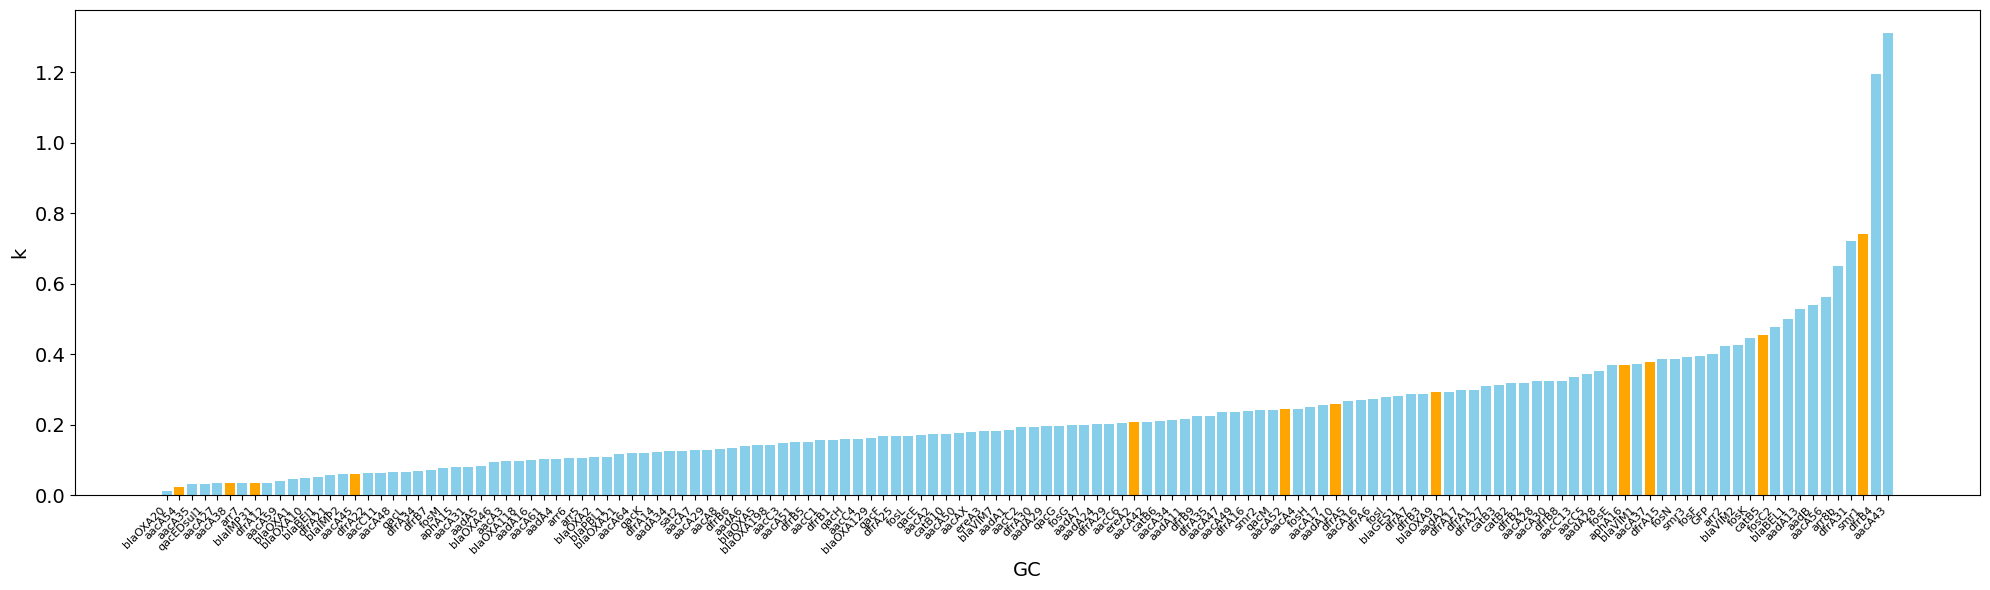

In [ ]:


colors = ['orange' if gene in filter_values else 'skyblue' for gene in gene_labels]

# Pair gene_labels and k_values_all, then sort by k_values_all
sorted_data = sorted(zip(k_values_all, gene_labels, colors))
sorted_k_values, sorted_gene_labels, sorted_colors = zip(*sorted_data)


# Create the bar plot
plt.figure(figsize=(20, 6))
plt.bar(sorted_gene_labels, sorted_k_values, color=sorted_colors)

# Add labels and title
plt.xlabel("GC", fontsize=14)
plt.ylabel("k", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(False)

# Rotate GC labels for readability
plt.xticks(rotation=45, ha='right', fontsize=8)
#plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()


# Numerical simulations

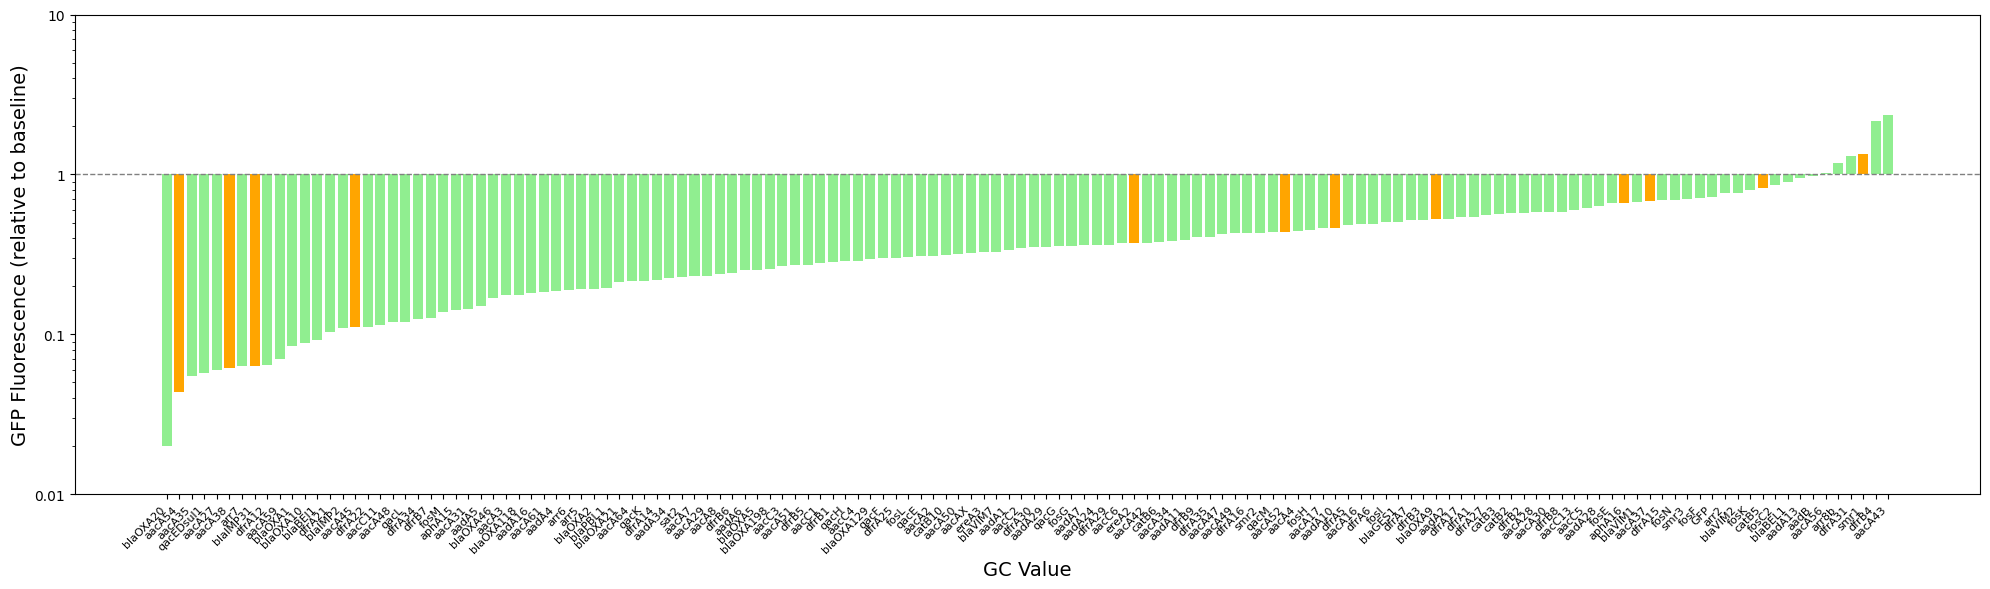

In [ ]:
# Initialize lists to store the GFP values from the model
gfp_values = []


# Run the model for each k_value and store the GFP result adjusted to baseline
for k_GC in k_values_all:
    this_k_values = [k_GC, k_GFP]
    this_gfp_value = getGFP(alpha, beta, delta, d_base, this_k_values,  m_initial, p_initial, t)
    gfp_values.append(this_gfp_value)  # Adjust to baseline by subtracting 1


# Calculate the bar heights relative to the baseline at 1
bar_heights = [gfp - 1 for gfp in gfp_values]


colors = ['orange' if gene in filter_values else 'lightgreen' for gene in gene_labels]

sorted_data = sorted(zip(bar_heights, gene_labels, colors))
sorted_bar_heights, sorted_gene_labels, sorted_colors = zip(*sorted_data)


# Plot with baseline at y=1 and use the heights calculated
plt.figure(figsize=(20, 6))
plt.bar(sorted_gene_labels, sorted_bar_heights, color=sorted_colors, bottom=1)

# Set y-axis to logarithmic scale and define the y-axis limits
plt.yscale('log')
plt.ylim([0.01, 5])

# Set specific y-axis tick labels
plt.yticks([0.01, 0.1, 1, 10], ["0.01", "0.1", "1", "10"])

# Add a horizontal line at y=1 to represent the baseline
plt.axhline(1, color='gray', linestyle='--', linewidth=1)

# Add labels and title
plt.xlabel("GC Value", fontsize=14)
plt.ylabel("GFP Fluorescence (relative to baseline)", fontsize=14)

# Rotate GC labels for readability
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.tight_layout()

# Show the plot
plt.show()


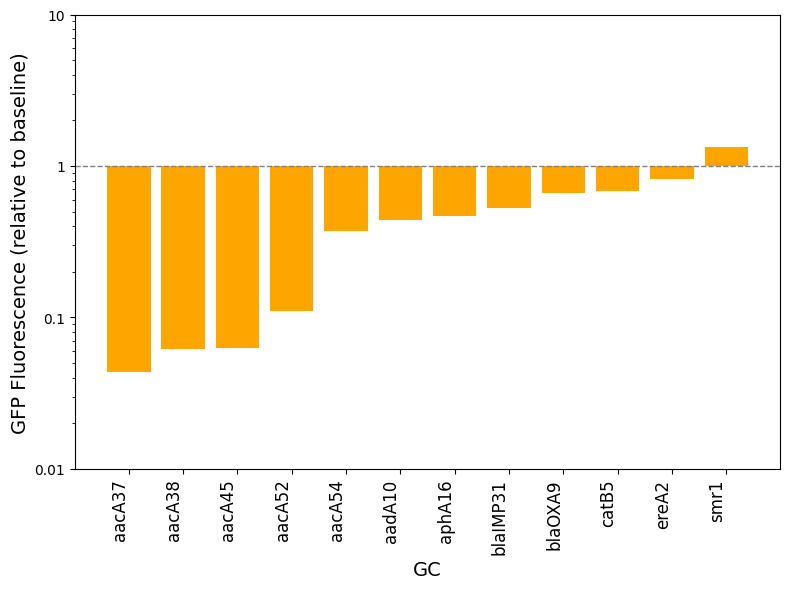

In [ ]:
# Filter only the values in filter_values
filtered_bar_heights = [bar_height for bar_height, gene in zip(sorted_bar_heights, sorted_gene_labels) if gene in filter_values]
filtered_gene_labels = [gene for gene in gene_labels if gene in filter_values]

# Plot only the filtered values with baseline at y=1
plt.figure(figsize=(8, 6))
plt.bar(filtered_gene_labels, filtered_bar_heights, color='orange', bottom=1)

# Set y-axis to logarithmic scale and define the y-axis limits
plt.yscale('log')
plt.ylim([0.01, 5])

# Set specific y-axis tick labels
plt.yticks([0.01, 0.1, 1, 10], ["0.01", "0.1", "1", "10"])

# Add a horizontal line at y=1 to represent the baseline
plt.axhline(1, color='gray', linestyle='--', linewidth=1)

# Add labels and title
plt.xlabel("GC", fontsize=14)
plt.ylabel("GFP Fluorescence (relative to baseline)", fontsize=14)

# Rotate GC labels for readability
plt.xticks(rotation=90, ha='right', fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()




## Evaluating order of upstream cassettes

In [ ]:

# Authenticate and authorize access to Google Sheets
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Open the Google Sheet by URL
sheetGC = gc.open_by_url(sheet_url)

# Load and process the 'Fluorescence' sheet
worksheet_fluorescenceGC = sheetGC.worksheet('FluorescenceGC')
df_fluorescenceGC = get_as_dataframe(worksheet_fluorescenceGC, header=0)

print(df_fluorescenceGC)



       GC1       GC2  GC3       GFP
0   aacA37    aphA16  GFP  0.285129
1   aacA37     catB5  GFP  0.257697
2   aacA37      smr1  GFP       NaN
3   aacA37     ereA2  GFP  0.245080
4   aacA37    aacA52  GFP  0.229460
5   aacA37   blaOXA9  GFP  0.284173
6   aacA37    aacA45  GFP  0.054106
7   aacA37    aacA38  GFP  0.020346
8   aacA37  blaIMP31  GFP  0.039793
9   aadA10    aphA16  GFP  0.119519
10  aadA10     catB5  GFP  0.193562
11  aadA10      smr1  GFP       NaN
12  aadA10     ereA2  GFP  0.178019
13  aadA10    aacA52  GFP  0.141571
14  aadA10   blaOXA9  GFP  0.220429
15  aadA10    aacA45  GFP  0.058582
16  aadA10    aacA38  GFP  0.021061
17  aadA10  blaIMP31  GFP  0.030983
18  aacA54    aphA16  GFP  0.005622
19  aacA54     catB5  GFP  0.022787
20  aacA54      smr1  GFP       NaN
21  aacA54     ereA2  GFP  0.026973
22  aacA54    aacA52  GFP  0.023909
23  aacA54   blaOXA9  GFP  0.046113
24  aacA54    aacA45  GFP  0.012129
25  aacA54    aacA38  GFP  0.004307
26  aacA54  blaIMP31  GFP  0

In [ ]:
# Iterate through each row in the dataframe and define test_gene_labels dynamically
for index, row in df_fluorescenceGC.iterrows():
    # Define test_gene_labels based on the current row
    test_gene_labels = [row['GC1'], row['GC2'], row['GC3']]

    # Extract the GFP value for the current row
    gfp_value = row['GFP']

    # Display or process the test_gene_labels and GFP value
    print(f"Row {index + 1}: test_gene_labels = {test_gene_labels}, GFP = {gfp_value}")

    # Here you can continue with further analysis or calculations for each test_gene_labels set
    # For example, you can use gfp_value in computations like deviation analysis as before


Row 1: test_gene_labels = ['aacA37', 'aphA16', 'GFP'], GFP = 0.2851285933005925
Row 2: test_gene_labels = ['aacA37', 'catB5', 'GFP'], GFP = 0.2576965999831294
Row 3: test_gene_labels = ['aacA37', 'smr1', 'GFP'], GFP = nan
Row 4: test_gene_labels = ['aacA37', 'ereA2', 'GFP'], GFP = 0.24508040020573138
Row 5: test_gene_labels = ['aacA37', 'aacA52', 'GFP'], GFP = 0.2294600447443325
Row 6: test_gene_labels = ['aacA37', 'blaOXA9', 'GFP'], GFP = 0.2841731164845933
Row 7: test_gene_labels = ['aacA37', 'aacA45', 'GFP'], GFP = 0.054105907232116425
Row 8: test_gene_labels = ['aacA37', 'aacA38', 'GFP'], GFP = 0.020345576001759336
Row 9: test_gene_labels = ['aacA37', 'blaIMP31', 'GFP'], GFP = 0.03979292535161213
Row 10: test_gene_labels = ['aadA10', 'aphA16', 'GFP'], GFP = 0.11951947244386618
Row 11: test_gene_labels = ['aadA10', 'catB5', 'GFP'], GFP = 0.19356171306446424
Row 12: test_gene_labels = ['aadA10', 'smr1', 'GFP'], GFP = nan
Row 13: test_gene_labels = ['aadA10', 'ereA2', 'GFP'], GFP = 0.

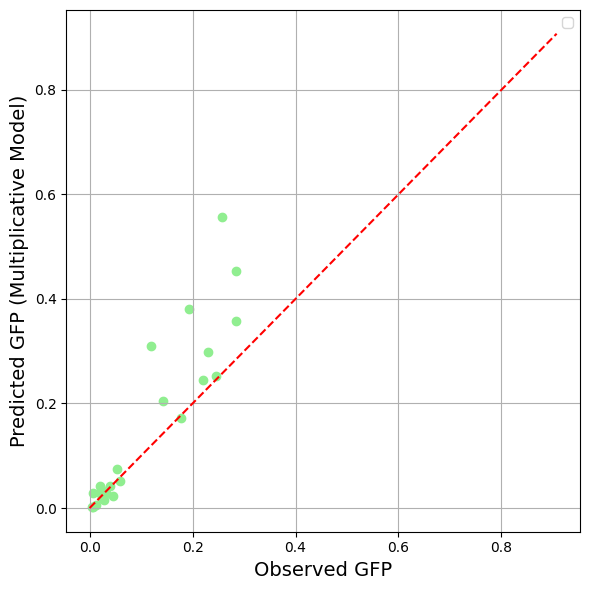

In [ ]:

# Lists to store observed and predicted GFP values for plotting
data_observed_gfp_values = []
data_predicted_gfp_values = []
data_deviations = []
data_combinations = []  # To keep track of gene combinations for reference if needed

# Iterate through each row in df_fluorescenceGC
for index, row in df_fluorescenceGC.iterrows():
    # Define test_gene_labels based on the current row
    test_gene_labels = [row['GC1'], row['GC2'], row['GC3']]

    # Filter df_data to get fluorescence values for individual genes
    test_df_data = df_data[df_data['GC'].isin(test_gene_labels)]

    # Find the matching row in df_fluorescenceGC for the current test_gene_labels
    matching_row = df_fluorescenceGC[
        (df_fluorescenceGC['GC1'] == test_gene_labels[0]) &
        (df_fluorescenceGC['GC2'] == test_gene_labels[1])
    ]

    # Extract the GFP value if there's a match
    data_gfp_value = matching_row['GFP'].values[0] if not matching_row.empty else None

    # Proceed only if GFP value is found
    if data_gfp_value is not None:
        # Step 1: Retrieve fluorescence values for individual genes from test_df_data
        data_gene1_fluorescence = test_df_data.loc[test_df_data['GC'] == test_gene_labels[0], 'Fluorescence'].values[0]
        data_gene2_fluorescence = test_df_data.loc[test_df_data['GC'] == test_gene_labels[1], 'Fluorescence'].values[0]

        # Step 2: Calculate predicted GFP as the product of individual fluorescence values
        data_predicted_gfp = data_gene1_fluorescence * data_gene2_fluorescence

        # Step 3: Calculate the deviation from the multiplicative model
        data_deviation = (data_gfp_value - data_predicted_gfp) / data_predicted_gfp

        # Store the values for plotting
        data_observed_gfp_values.append(data_gfp_value)
        data_predicted_gfp_values.append(data_predicted_gfp)
        data_deviations.append(data_deviation)
        data_combinations.append(f"{test_gene_labels[0]}-{test_gene_labels[1]}")

# Create the plot
plt.figure(figsize=(6, 6))
plt.scatter(data_observed_gfp_values, data_predicted_gfp_values, c='lightgreen')
plt.plot([0, max(data_predicted_gfp_values)], [0, max(data_predicted_gfp_values)], 'r--')
plt.ylabel("Predicted GFP (Multiplicative Model)", fontsize=14)
plt.xlabel("Observed GFP", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


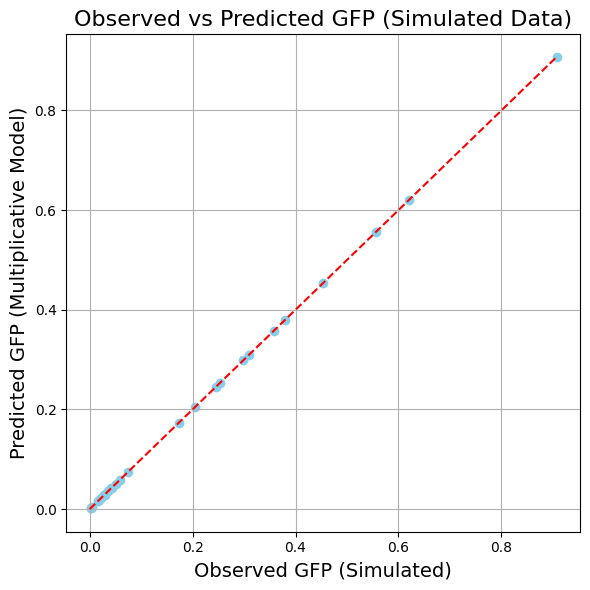

In [ ]:

# Lists to store observed and predicted GFP values for plotting
model_observed_gfp_values = []
model_predicted_gfp_values = []
model_deviations = []
model_combinations = []  # To keep track of gene combinations for reference if needed

# Iterate through each row in df_fluorescenceGC to get combinations of GC1 and GC2
for index, row in df_fluorescenceGC.iterrows():
    # Define test_gene_labels based on the current row
    test_gene_labels = [row['GC1'], row['GC2'], row['GC3']]

    # Retrieve synthetic k_values for the selected genes
    test_k_values = [k_values_all[gene_labels.index(gene)] for gene in test_gene_labels]


    # Run the synthetic experiment to get the observed GFP value
    permutations_list = {
        "[GFP]": [(2,)],
        "[1, GFP]": [(0, 2)],
        "[2, GFP]": [(1, 2)],
        "[1, 2, GFP]": [(0, 1, 2)]
    }

    values_dict = {
        "[GFP]": [run_experiment(perm, test_k_values) for perm in permutations_list["[GFP]"]],
        "[1, GFP]": [run_experiment(perm, test_k_values) for perm in permutations_list["[1, GFP]"]],
        "[2, GFP]": [run_experiment(perm, test_k_values) for perm in permutations_list["[2, GFP]"]],
        "[1, 2, GFP]": [run_experiment(perm, test_k_values) for perm in permutations_list["[1, 2, GFP]"]]
    }

    model_observed_gfp = values_dict["[1, 2, GFP]"][0]/values_dict["[GFP]"][0]  # Get the observed GFP value from synthetic data

    model_predicted_gfp = (values_dict["[1, GFP]"][0]/values_dict["[GFP]"][0]) * (values_dict["[2, GFP]"][0]/values_dict["[GFP]"][0])  # Predicted GFP as the product of single gene GFP

    # Calculate deviation
    model_deviation = (model_observed_gfp - model_predicted_gfp) / model_predicted_gfp

    # Store the values for plotting
    model_observed_gfp_values.append(model_observed_gfp)
    model_predicted_gfp_values.append(model_predicted_gfp)
    model_deviations.append(model_deviation)
    model_combinations.append(f"{test_gene_labels[0]}-{test_gene_labels[1]}")

# Create the plot
plt.figure(figsize=(6, 6))
plt.scatter(model_observed_gfp_values, model_predicted_gfp_values, c='skyblue')
plt.plot([0, max(model_predicted_gfp_values)], [0, max(model_predicted_gfp_values)], 'r--')
plt.xlabel("Observed GFP (Simulated)", fontsize=14)
plt.ylabel("Predicted GFP (Multiplicative Model)", fontsize=14)
plt.title("Observed vs Predicted GFP (Simulated Data)", fontsize=16)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


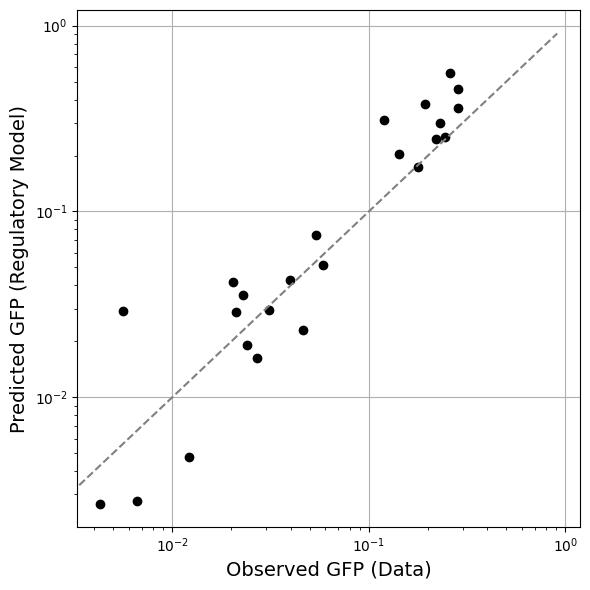

In [ ]:
# Create a scatter plot to compare data vs. regulatory model predictions
plt.figure(figsize=(6, 6))

# Plot observed data GFP values vs. predicted regulatory model GFP values
plt.scatter(data_observed_gfp_values, model_predicted_gfp_values, c='black')
plt.plot([0, max(max(data_observed_gfp_values), max(model_predicted_gfp_values))],
         [0, max(max(data_observed_gfp_values), max(model_predicted_gfp_values))], '--', color='gray')

# Label the plot
plt.xlabel("Observed GFP (Data)", fontsize=14)
plt.ylabel("Predicted GFP (Regulatory Model)", fontsize=14)
plt.yscale("log")
plt.xscale("log")
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


# Permutations

In [ ]:

def plotExpressionPermutation(permutations_list, gene_labels, values_dict, color='skyblue'):
    """
    Plots the final protein concentration of the focal gene (Gene 3) for each permutation as a bar plot.

    Parameters:
        permutations_list (list): List of permutations showing the order of genes.
        values_dict (dict): Dictionary of protein concentrations of the focal gene for each case (position).
    """
    x_labels = []
    bar_values = []

    # Prepare data for the bar plot
    for position, values in values_dict.items():
        label = ', '.join([gene_labels[gene] for gene in permutations_list[position][0]])
        x_labels.append(label)
        bar_values.append(values[0])

    plt.figure(figsize=(6, 6))
    plt.bar(x_labels, bar_values, color=color)

    if color == 'lightgreen':
        plt.title('Experimental data')
    else:
        plt.title('Simulated data')

    plt.ylabel('GFP (log)', fontsize=16)
    plt.xticks(rotation=90, fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.yscale('log')
    plt.show()


Simulating:  ['aacA37', 'aphA16', 'GFP']


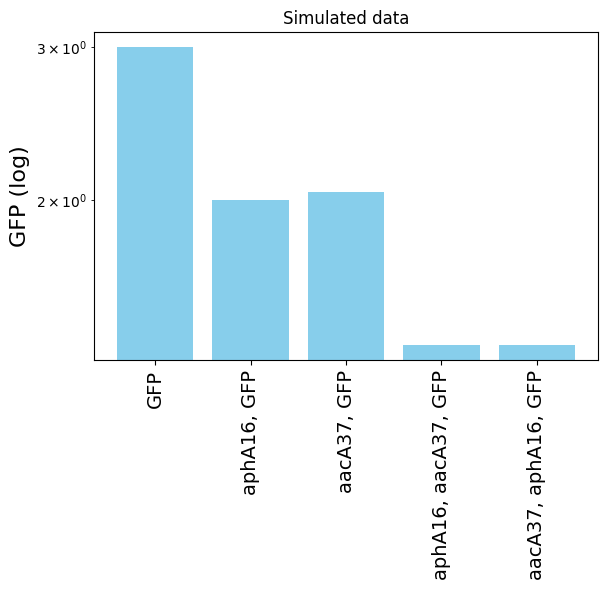

	Combination 111: Total protein concentration of X = 0
	Combination 112: Total protein concentration of X = 0
	Combination 11X: Total protein concentration of X = 1.3895788225669246
	Combination 110: Total protein concentration of X = 0
	Combination 121: Total protein concentration of X = 0
	Combination 122: Total protein concentration of X = 0
	Combination 12X: Total protein concentration of X = 1.3600651546024234
	Combination 120: Total protein concentration of X = 0
	Combination 1X1: Total protein concentration of X = 2.041748385008141
	Combination 1X2: Total protein concentration of X = 2.0417483850071725
	Combination 1XX: Total protein concentration of X = 3.5118072222187333
	Combination 1X0: Total protein concentration of X = 2.04174838500765
	Combination 100: Total protein concentration of X = 0
	Combination 211: Total protein concentration of X = 0
	Combination 212: Total protein concentration of X = 0
	Combination 21X: Total protein concentration of X = 1.36006515462297
	Combi

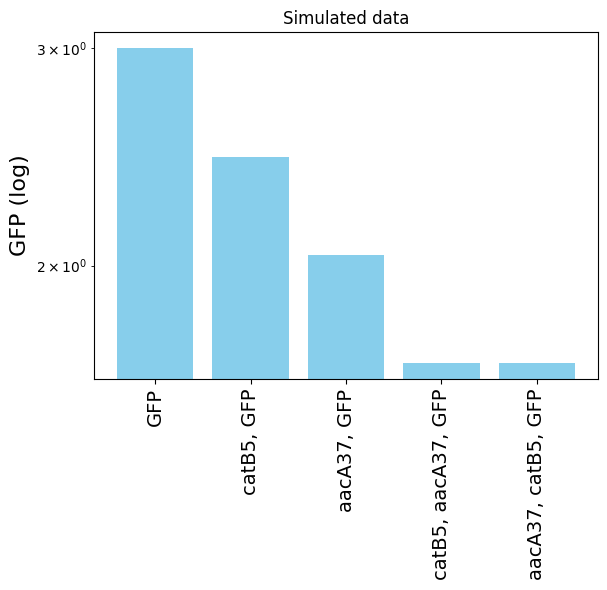

	Combination 111: Total protein concentration of X = 0
	Combination 112: Total protein concentration of X = 0
	Combination 11X: Total protein concentration of X = 1.3895788225669246
	Combination 110: Total protein concentration of X = 0
	Combination 121: Total protein concentration of X = 0
	Combination 122: Total protein concentration of X = 0
	Combination 12X: Total protein concentration of X = 1.6682096449804122
	Combination 120: Total protein concentration of X = 0
	Combination 1X1: Total protein concentration of X = 2.041748385008141
	Combination 1X2: Total protein concentration of X = 2.041748384999241
	Combination 1XX: Total protein concentration of X = 3.5118072222187333
	Combination 1X0: Total protein concentration of X = 2.04174838500765
	Combination 100: Total protein concentration of X = 0
	Combination 211: Total protein concentration of X = 0
	Combination 212: Total protein concentration of X = 0
	Combination 21X: Total protein concentration of X = 1.6682096450201929
	Comb

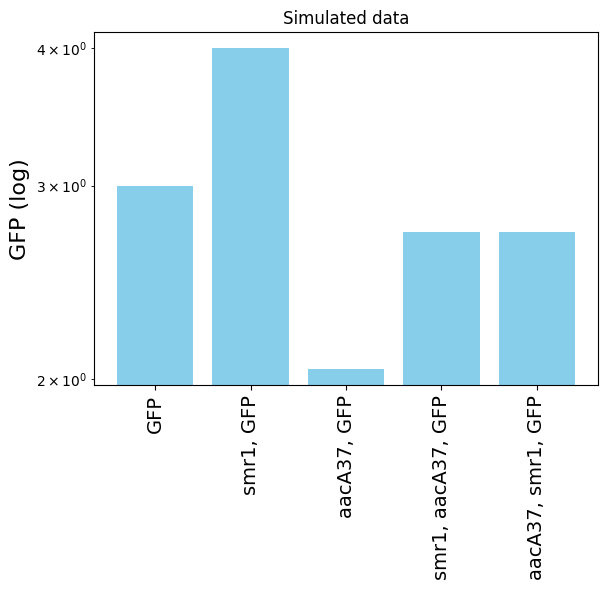

	Combination 111: Total protein concentration of X = 0
	Combination 112: Total protein concentration of X = 0
	Combination 11X: Total protein concentration of X = 1.3895788225669246
	Combination 110: Total protein concentration of X = 0
	Combination 121: Total protein concentration of X = 0
	Combination 122: Total protein concentration of X = 0
	Combination 12X: Total protein concentration of X = 2.721650578704505
	Combination 120: Total protein concentration of X = 0
	Combination 1X1: Total protein concentration of X = 2.041748385008141
	Combination 1X2: Total protein concentration of X = 2.0417483850108242
	Combination 1XX: Total protein concentration of X = 3.5118072222187333
	Combination 1X0: Total protein concentration of X = 2.04174838500765
	Combination 100: Total protein concentration of X = 0
	Combination 211: Total protein concentration of X = 0
	Combination 212: Total protein concentration of X = 0
	Combination 21X: Total protein concentration of X = 2.721650578795388
	Combi

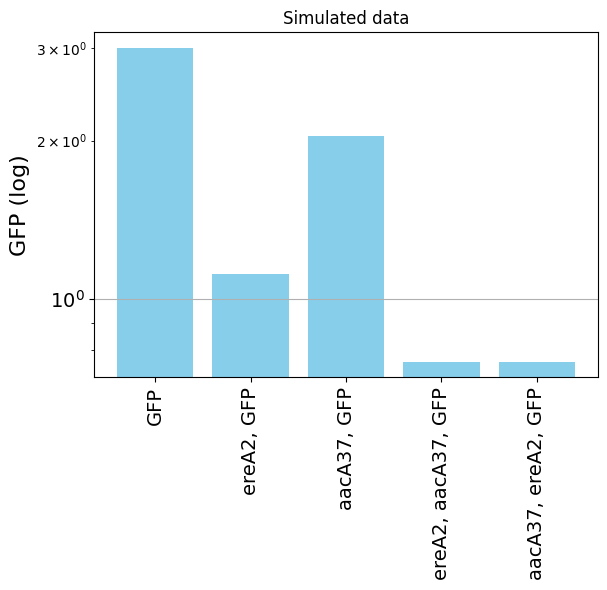

	Combination 111: Total protein concentration of X = 0
	Combination 112: Total protein concentration of X = 0
	Combination 11X: Total protein concentration of X = 1.3895788225669246
	Combination 110: Total protein concentration of X = 0
	Combination 121: Total protein concentration of X = 0
	Combination 122: Total protein concentration of X = 0
	Combination 12X: Total protein concentration of X = 0.7594915422926164
	Combination 120: Total protein concentration of X = 0
	Combination 1X1: Total protein concentration of X = 2.041748385008141
	Combination 1X2: Total protein concentration of X = 2.0417483849967812
	Combination 1XX: Total protein concentration of X = 3.5118072222187333
	Combination 1X0: Total protein concentration of X = 2.04174838500765
	Combination 100: Total protein concentration of X = 0
	Combination 211: Total protein concentration of X = 0
	Combination 212: Total protein concentration of X = 0
	Combination 21X: Total protein concentration of X = 0.7594915439783189
	Com

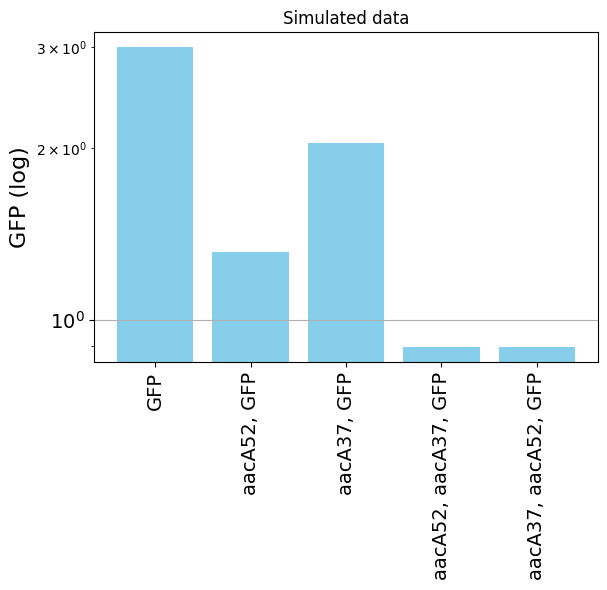

	Combination 111: Total protein concentration of X = 0
	Combination 112: Total protein concentration of X = 0
	Combination 11X: Total protein concentration of X = 1.3895788225669246
	Combination 110: Total protein concentration of X = 0
	Combination 121: Total protein concentration of X = 0
	Combination 122: Total protein concentration of X = 0
	Combination 12X: Total protein concentration of X = 0.8956108322668169
	Combination 120: Total protein concentration of X = 0
	Combination 1X1: Total protein concentration of X = 2.041748385008141
	Combination 1X2: Total protein concentration of X = 2.0417483850141402
	Combination 1XX: Total protein concentration of X = 3.5118072222187333
	Combination 1X0: Total protein concentration of X = 2.04174838500765
	Combination 100: Total protein concentration of X = 0
	Combination 211: Total protein concentration of X = 0
	Combination 212: Total protein concentration of X = 0
	Combination 21X: Total protein concentration of X = 0.8956108323349213
	Com

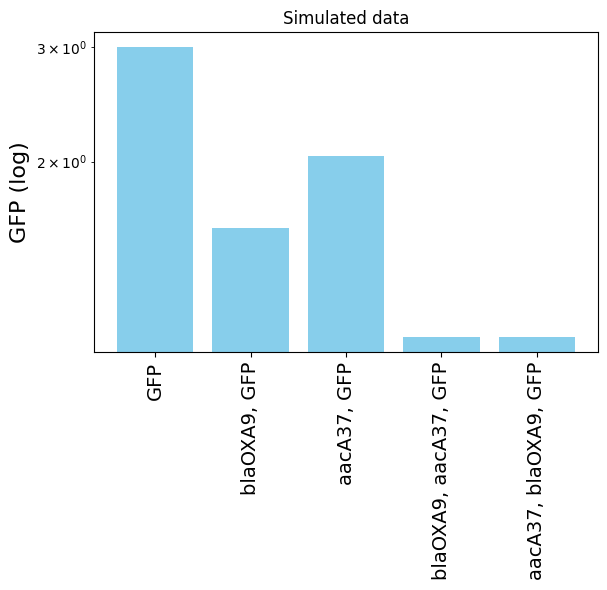

	Combination 111: Total protein concentration of X = 0
	Combination 112: Total protein concentration of X = 0
	Combination 11X: Total protein concentration of X = 1.3895788225669246
	Combination 110: Total protein concentration of X = 0
	Combination 121: Total protein concentration of X = 0
	Combination 122: Total protein concentration of X = 0
	Combination 12X: Total protein concentration of X = 1.0750021297433145
	Combination 120: Total protein concentration of X = 0
	Combination 1X1: Total protein concentration of X = 2.041748385008141
	Combination 1X2: Total protein concentration of X = 2.0417483850186273
	Combination 1XX: Total protein concentration of X = 3.5118072222187333
	Combination 1X0: Total protein concentration of X = 2.04174838500765
	Combination 100: Total protein concentration of X = 0
	Combination 211: Total protein concentration of X = 0
	Combination 212: Total protein concentration of X = 0
	Combination 21X: Total protein concentration of X = 1.0750021297639747
	Com

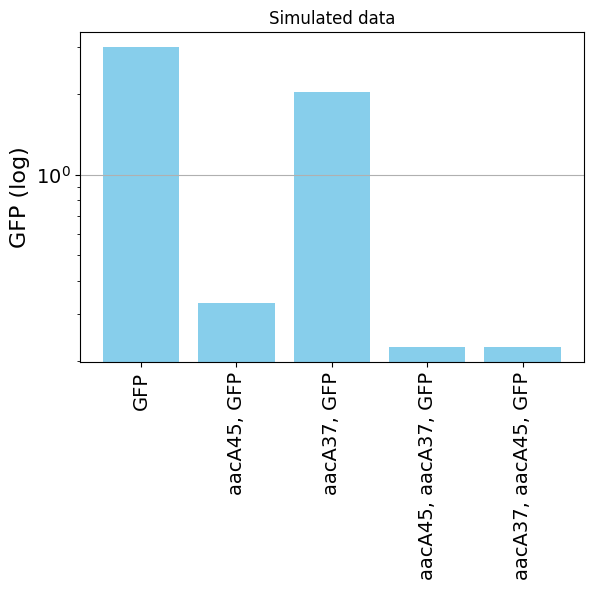

	Combination 111: Total protein concentration of X = 0
	Combination 112: Total protein concentration of X = 0
	Combination 11X: Total protein concentration of X = 1.3895788225669246
	Combination 110: Total protein concentration of X = 0
	Combination 121: Total protein concentration of X = 0
	Combination 122: Total protein concentration of X = 0
	Combination 12X: Total protein concentration of X = 0.2251226269268826
	Combination 120: Total protein concentration of X = 0
	Combination 1X1: Total protein concentration of X = 2.041748385008141
	Combination 1X2: Total protein concentration of X = 2.041748387692656
	Combination 1XX: Total protein concentration of X = 3.5118072222187333
	Combination 1X0: Total protein concentration of X = 2.04174838500765
	Combination 100: Total protein concentration of X = 0
	Combination 211: Total protein concentration of X = 0
	Combination 212: Total protein concentration of X = 0
	Combination 21X: Total protein concentration of X = 0.2251226268840152
	Comb

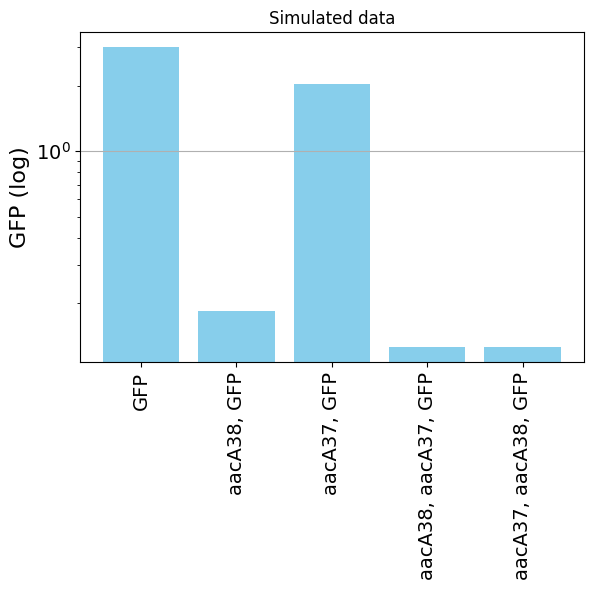

	Combination 111: Total protein concentration of X = 0
	Combination 112: Total protein concentration of X = 0
	Combination 11X: Total protein concentration of X = 1.3895788225669246
	Combination 110: Total protein concentration of X = 0
	Combination 121: Total protein concentration of X = 0
	Combination 122: Total protein concentration of X = 0
	Combination 12X: Total protein concentration of X = 0.12560492402308887
	Combination 120: Total protein concentration of X = 0
	Combination 1X1: Total protein concentration of X = 2.041748385008141
	Combination 1X2: Total protein concentration of X = 2.0417483856195067
	Combination 1XX: Total protein concentration of X = 3.5118072222187333
	Combination 1X0: Total protein concentration of X = 2.04174838500765
	Combination 100: Total protein concentration of X = 0
	Combination 211: Total protein concentration of X = 0
	Combination 212: Total protein concentration of X = 0
	Combination 21X: Total protein concentration of X = 0.1256049238804081
	Co

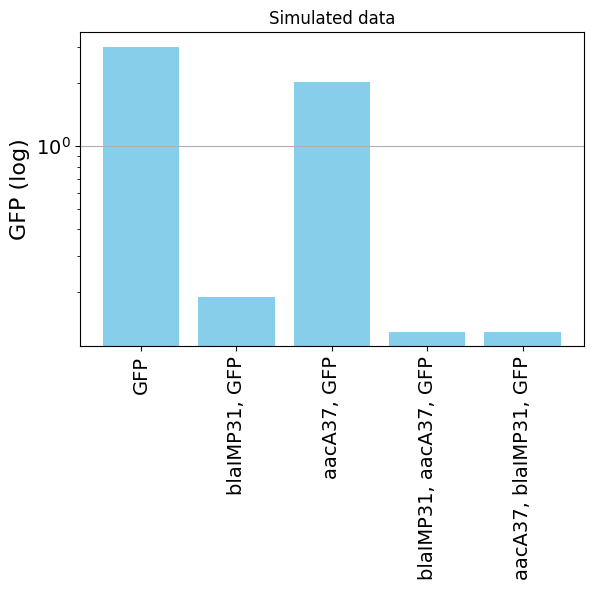

	Combination 111: Total protein concentration of X = 0
	Combination 112: Total protein concentration of X = 0
	Combination 11X: Total protein concentration of X = 1.3895788225669246
	Combination 110: Total protein concentration of X = 0
	Combination 121: Total protein concentration of X = 0
	Combination 122: Total protein concentration of X = 0
	Combination 12X: Total protein concentration of X = 0.1290606359734106
	Combination 120: Total protein concentration of X = 0
	Combination 1X1: Total protein concentration of X = 2.041748385008141
	Combination 1X2: Total protein concentration of X = 2.0417483850009246
	Combination 1XX: Total protein concentration of X = 3.5118072222187333
	Combination 1X0: Total protein concentration of X = 2.04174838500765
	Combination 100: Total protein concentration of X = 0
	Combination 211: Total protein concentration of X = 0
	Combination 212: Total protein concentration of X = 0
	Combination 21X: Total protein concentration of X = 0.12906063595712883
	Co

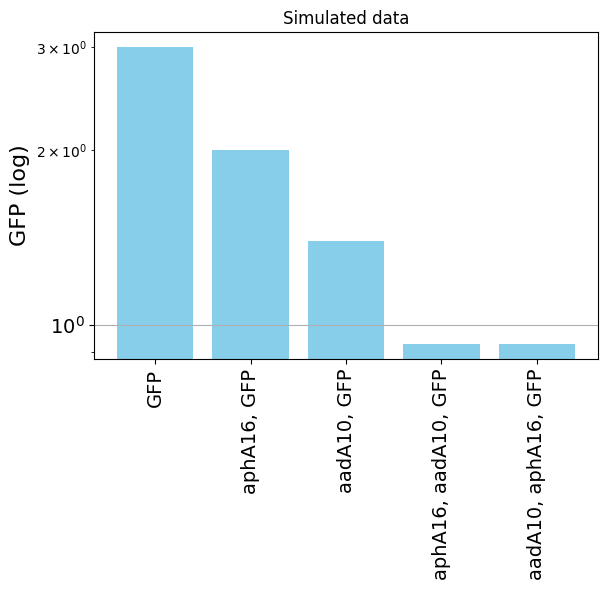

	Combination 111: Total protein concentration of X = 0
	Combination 112: Total protein concentration of X = 0
	Combination 11X: Total protein concentration of X = 0.64833196927464
	Combination 110: Total protein concentration of X = 0
	Combination 121: Total protein concentration of X = 0
	Combination 122: Total protein concentration of X = 0
	Combination 12X: Total protein concentration of X = 0.9290024069205287
	Combination 120: Total protein concentration of X = 0
	Combination 1X1: Total protein concentration of X = 1.394631100989673
	Combination 1X2: Total protein concentration of X = 1.3946311009794194
	Combination 1XX: Total protein concentration of X = 2.398765493690397
	Combination 1X0: Total protein concentration of X = 1.3946311009828323
	Combination 100: Total protein concentration of X = 0
	Combination 211: Total protein concentration of X = 0
	Combination 212: Total protein concentration of X = 0
	Combination 21X: Total protein concentration of X = 0.9290024069152134
	Comb

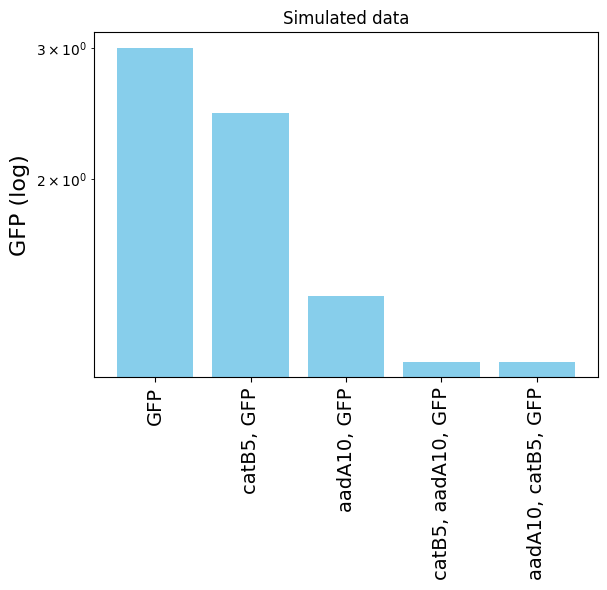

	Combination 111: Total protein concentration of X = 0
	Combination 112: Total protein concentration of X = 0
	Combination 11X: Total protein concentration of X = 0.64833196927464
	Combination 110: Total protein concentration of X = 0
	Combination 121: Total protein concentration of X = 0
	Combination 122: Total protein concentration of X = 0
	Combination 12X: Total protein concentration of X = 1.1394827448203768
	Combination 120: Total protein concentration of X = 0
	Combination 1X1: Total protein concentration of X = 1.394631100989673
	Combination 1X2: Total protein concentration of X = 1.394631101038172
	Combination 1XX: Total protein concentration of X = 2.398765493690397
	Combination 1X0: Total protein concentration of X = 1.3946311009828323
	Combination 100: Total protein concentration of X = 0
	Combination 211: Total protein concentration of X = 0
	Combination 212: Total protein concentration of X = 0
	Combination 21X: Total protein concentration of X = 1.1394827447322025
	Combi

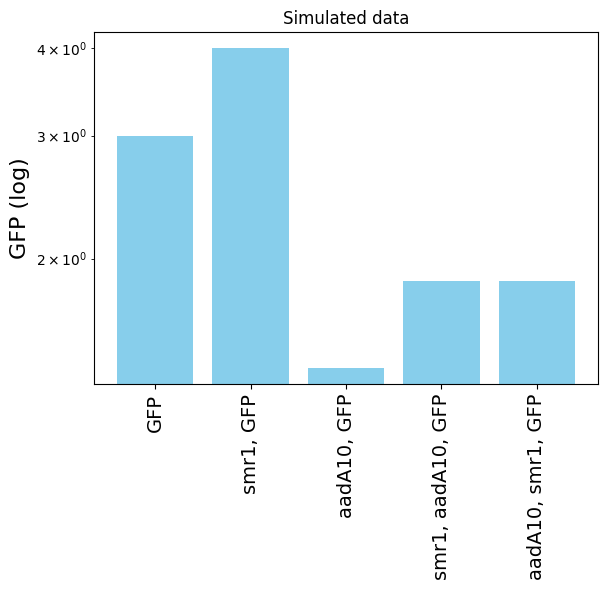

	Combination 111: Total protein concentration of X = 0
	Combination 112: Total protein concentration of X = 0
	Combination 11X: Total protein concentration of X = 0.64833196927464
	Combination 110: Total protein concentration of X = 0
	Combination 121: Total protein concentration of X = 0
	Combination 122: Total protein concentration of X = 0
	Combination 12X: Total protein concentration of X = 1.859043244994015
	Combination 120: Total protein concentration of X = 0
	Combination 1X1: Total protein concentration of X = 1.394631100989673
	Combination 1X2: Total protein concentration of X = 1.394631100998882
	Combination 1XX: Total protein concentration of X = 2.398765493690397
	Combination 1X0: Total protein concentration of X = 1.3946311009828323
	Combination 100: Total protein concentration of X = 0
	Combination 211: Total protein concentration of X = 0
	Combination 212: Total protein concentration of X = 0
	Combination 21X: Total protein concentration of X = 1.8590432450785381
	Combin

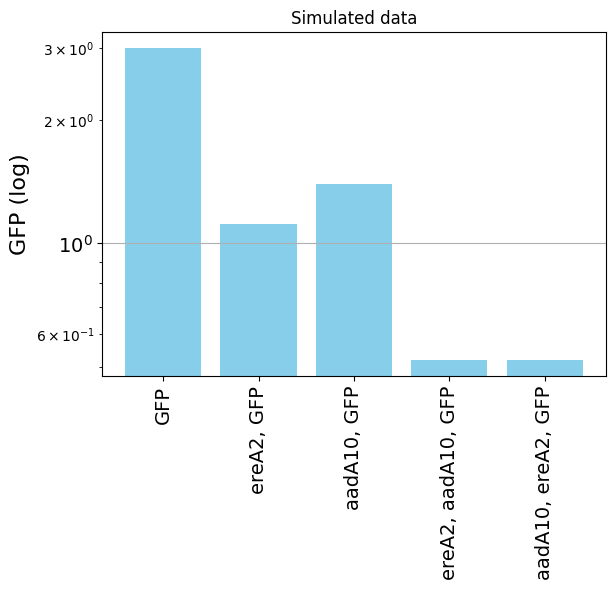

	Combination 111: Total protein concentration of X = 0
	Combination 112: Total protein concentration of X = 0
	Combination 11X: Total protein concentration of X = 0.64833196927464
	Combination 110: Total protein concentration of X = 0
	Combination 121: Total protein concentration of X = 0
	Combination 122: Total protein concentration of X = 0
	Combination 12X: Total protein concentration of X = 0.5187762270020954
	Combination 120: Total protein concentration of X = 0
	Combination 1X1: Total protein concentration of X = 1.394631100989673
	Combination 1X2: Total protein concentration of X = 1.394631100986304
	Combination 1XX: Total protein concentration of X = 2.398765493690397
	Combination 1X0: Total protein concentration of X = 1.3946311009828323
	Combination 100: Total protein concentration of X = 0
	Combination 211: Total protein concentration of X = 0
	Combination 212: Total protein concentration of X = 0
	Combination 21X: Total protein concentration of X = 0.5187762292043681
	Combi

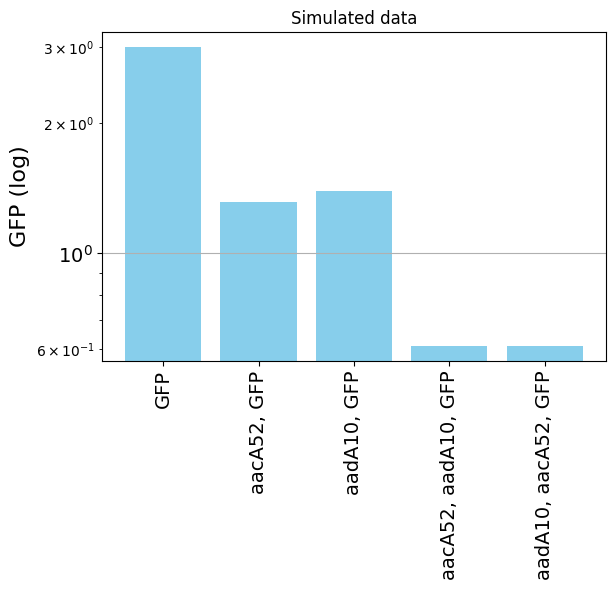

	Combination 111: Total protein concentration of X = 0
	Combination 112: Total protein concentration of X = 0
	Combination 11X: Total protein concentration of X = 0.64833196927464
	Combination 110: Total protein concentration of X = 0
	Combination 121: Total protein concentration of X = 0
	Combination 122: Total protein concentration of X = 0
	Combination 12X: Total protein concentration of X = 0.6117535001981372
	Combination 120: Total protein concentration of X = 0
	Combination 1X1: Total protein concentration of X = 1.394631100989673
	Combination 1X2: Total protein concentration of X = 1.3946310996554705
	Combination 1XX: Total protein concentration of X = 2.398765493690397
	Combination 1X0: Total protein concentration of X = 1.3946311009828323
	Combination 100: Total protein concentration of X = 0
	Combination 211: Total protein concentration of X = 0
	Combination 212: Total protein concentration of X = 0
	Combination 21X: Total protein concentration of X = 0.6117535002174553
	Comb

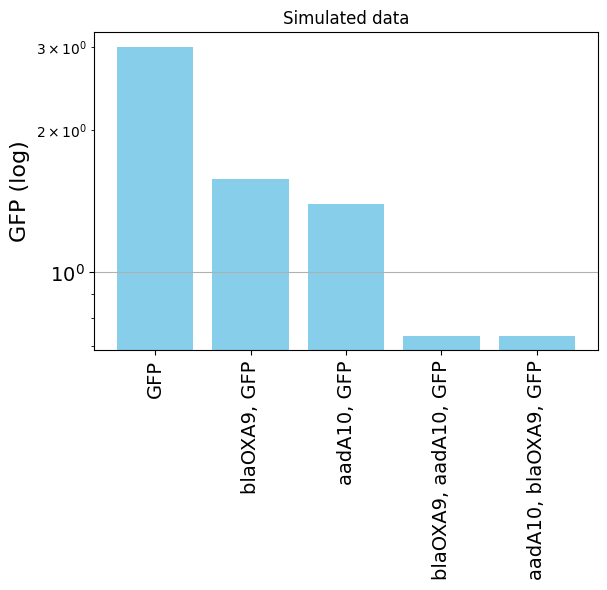

	Combination 111: Total protein concentration of X = 0
	Combination 112: Total protein concentration of X = 0
	Combination 11X: Total protein concentration of X = 0.64833196927464
	Combination 110: Total protein concentration of X = 0
	Combination 121: Total protein concentration of X = 0
	Combination 122: Total protein concentration of X = 0
	Combination 12X: Total protein concentration of X = 0.7342880323163588
	Combination 120: Total protein concentration of X = 0
	Combination 1X1: Total protein concentration of X = 1.394631100989673
	Combination 1X2: Total protein concentration of X = 1.3946311009875363
	Combination 1XX: Total protein concentration of X = 2.398765493690397
	Combination 1X0: Total protein concentration of X = 1.3946311009828323
	Combination 100: Total protein concentration of X = 0
	Combination 211: Total protein concentration of X = 0
	Combination 212: Total protein concentration of X = 0
	Combination 21X: Total protein concentration of X = 0.7342880321301288
	Comb

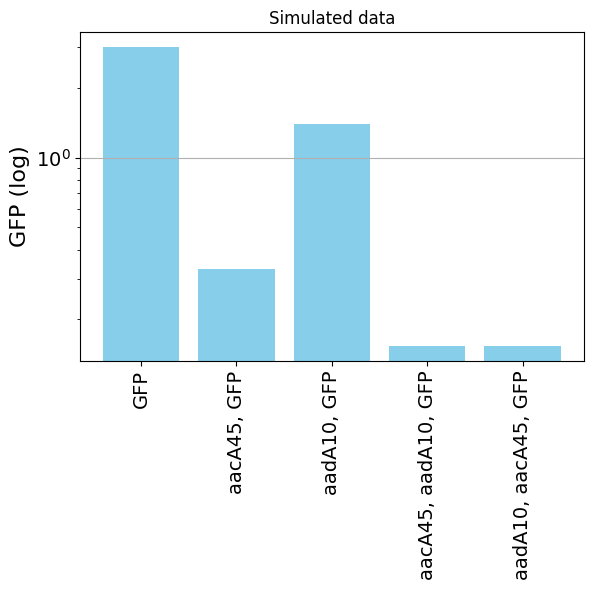

	Combination 111: Total protein concentration of X = 0
	Combination 112: Total protein concentration of X = 0
	Combination 11X: Total protein concentration of X = 0.64833196927464
	Combination 110: Total protein concentration of X = 0
	Combination 121: Total protein concentration of X = 0
	Combination 122: Total protein concentration of X = 0
	Combination 12X: Total protein concentration of X = 0.15377164911403943
	Combination 120: Total protein concentration of X = 0
	Combination 1X1: Total protein concentration of X = 1.394631100989673
	Combination 1X2: Total protein concentration of X = 1.3946310979418808
	Combination 1XX: Total protein concentration of X = 2.398765493690397
	Combination 1X0: Total protein concentration of X = 1.3946311009828323
	Combination 100: Total protein concentration of X = 0
	Combination 211: Total protein concentration of X = 0
	Combination 212: Total protein concentration of X = 0
	Combination 21X: Total protein concentration of X = 0.15377164951124164
	Co

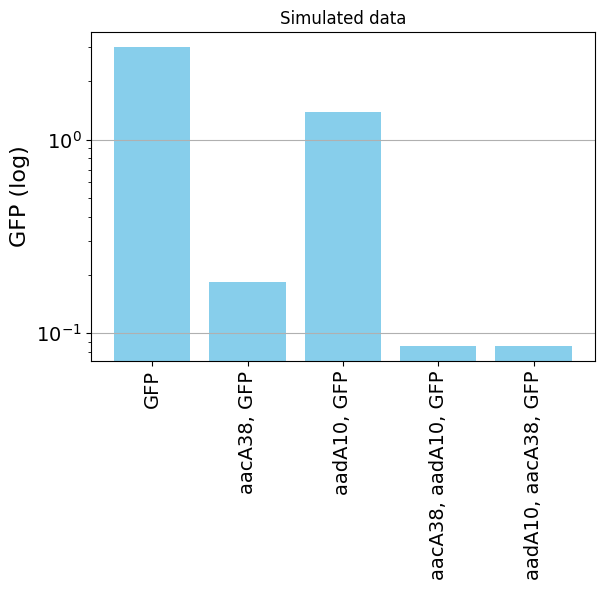

	Combination 111: Total protein concentration of X = 0
	Combination 112: Total protein concentration of X = 0
	Combination 11X: Total protein concentration of X = 0.64833196927464
	Combination 110: Total protein concentration of X = 0
	Combination 121: Total protein concentration of X = 0
	Combination 122: Total protein concentration of X = 0
	Combination 12X: Total protein concentration of X = 0.08579535786526522
	Combination 120: Total protein concentration of X = 0
	Combination 1X1: Total protein concentration of X = 1.394631100989673
	Combination 1X2: Total protein concentration of X = 1.3946311009811163
	Combination 1XX: Total protein concentration of X = 2.398765493690397
	Combination 1X0: Total protein concentration of X = 1.3946311009828323
	Combination 100: Total protein concentration of X = 0
	Combination 211: Total protein concentration of X = 0
	Combination 212: Total protein concentration of X = 0
	Combination 21X: Total protein concentration of X = 0.08579535784156717
	Co

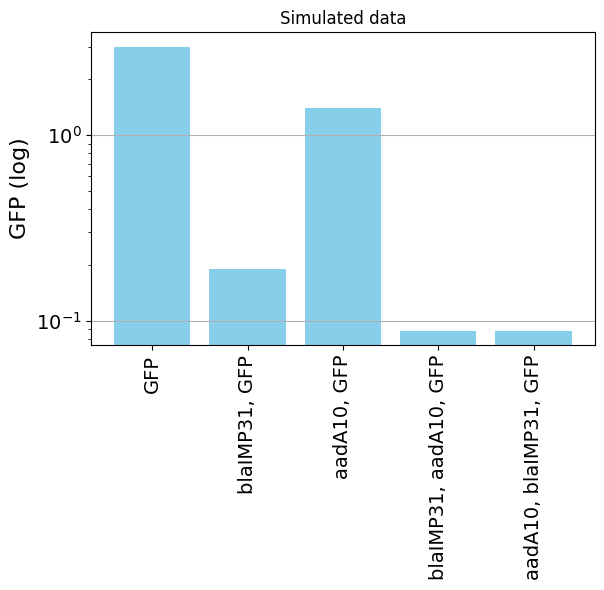

	Combination 111: Total protein concentration of X = 0
	Combination 112: Total protein concentration of X = 0
	Combination 11X: Total protein concentration of X = 0.64833196927464
	Combination 110: Total protein concentration of X = 0
	Combination 121: Total protein concentration of X = 0
	Combination 122: Total protein concentration of X = 0
	Combination 12X: Total protein concentration of X = 0.08815580713344388
	Combination 120: Total protein concentration of X = 0
	Combination 1X1: Total protein concentration of X = 1.394631100989673
	Combination 1X2: Total protein concentration of X = 1.3946311032772511
	Combination 1XX: Total protein concentration of X = 2.398765493690397
	Combination 1X0: Total protein concentration of X = 1.3946311009828323
	Combination 100: Total protein concentration of X = 0
	Combination 211: Total protein concentration of X = 0
	Combination 212: Total protein concentration of X = 0
	Combination 21X: Total protein concentration of X = 0.08815580700606687
	Co

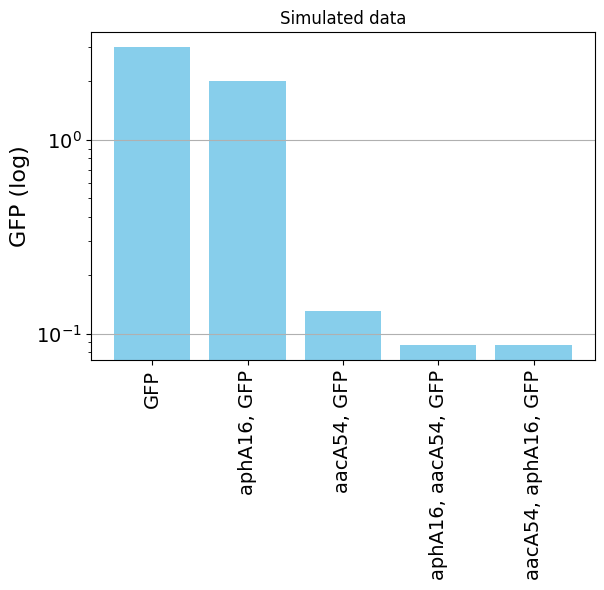

	Combination 111: Total protein concentration of X = 0
	Combination 112: Total protein concentration of X = 0
	Combination 11X: Total protein concentration of X = 0.005686244222159913
	Combination 110: Total protein concentration of X = 0
	Combination 121: Total protein concentration of X = 0
	Combination 122: Total protein concentration of X = 0
	Combination 12X: Total protein concentration of X = 0.08700232803009149
	Combination 120: Total protein concentration of X = 0
	Combination 1X1: Total protein concentration of X = 0.13060908340142735
	Combination 1X2: Total protein concentration of X = 0.13060908314714137
	Combination 1XX: Total protein concentration of X = 0.22464762301160968
	Combination 1X0: Total protein concentration of X = 0.13060908314628908
	Combination 100: Total protein concentration of X = 0
	Combination 211: Total protein concentration of X = 0
	Combination 212: Total protein concentration of X = 0
	Combination 21X: Total protein concentration of X = 0.08700232814

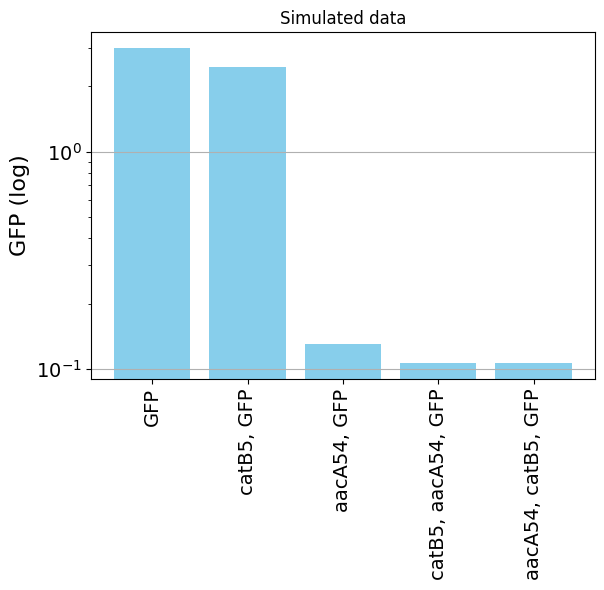

	Combination 111: Total protein concentration of X = 0
	Combination 112: Total protein concentration of X = 0
	Combination 11X: Total protein concentration of X = 0.005686244222159913
	Combination 110: Total protein concentration of X = 0
	Combination 121: Total protein concentration of X = 0
	Combination 122: Total protein concentration of X = 0
	Combination 12X: Total protein concentration of X = 0.10671409553831093
	Combination 120: Total protein concentration of X = 0
	Combination 1X1: Total protein concentration of X = 0.13060908340142735
	Combination 1X2: Total protein concentration of X = 0.13060908289104856
	Combination 1XX: Total protein concentration of X = 0.22464762301160968
	Combination 1X0: Total protein concentration of X = 0.13060908314628908
	Combination 100: Total protein concentration of X = 0
	Combination 211: Total protein concentration of X = 0
	Combination 212: Total protein concentration of X = 0
	Combination 21X: Total protein concentration of X = 0.10671409554

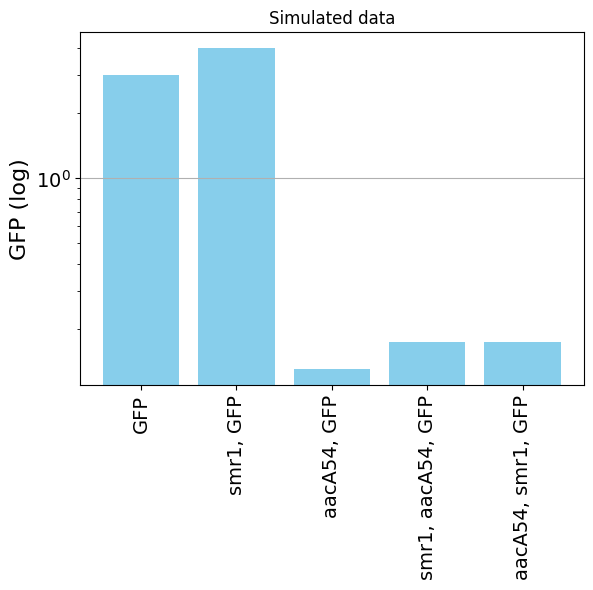

	Combination 111: Total protein concentration of X = 0
	Combination 112: Total protein concentration of X = 0
	Combination 11X: Total protein concentration of X = 0.005686244222159913
	Combination 110: Total protein concentration of X = 0
	Combination 121: Total protein concentration of X = 0
	Combination 122: Total protein concentration of X = 0
	Combination 12X: Total protein concentration of X = 0.17410190665347985
	Combination 120: Total protein concentration of X = 0
	Combination 1X1: Total protein concentration of X = 0.13060908340142735
	Combination 1X2: Total protein concentration of X = 0.1306090832124975
	Combination 1XX: Total protein concentration of X = 0.22464762301160968
	Combination 1X0: Total protein concentration of X = 0.13060908314628908
	Combination 100: Total protein concentration of X = 0
	Combination 211: Total protein concentration of X = 0
	Combination 212: Total protein concentration of X = 0
	Combination 21X: Total protein concentration of X = 0.174101906878

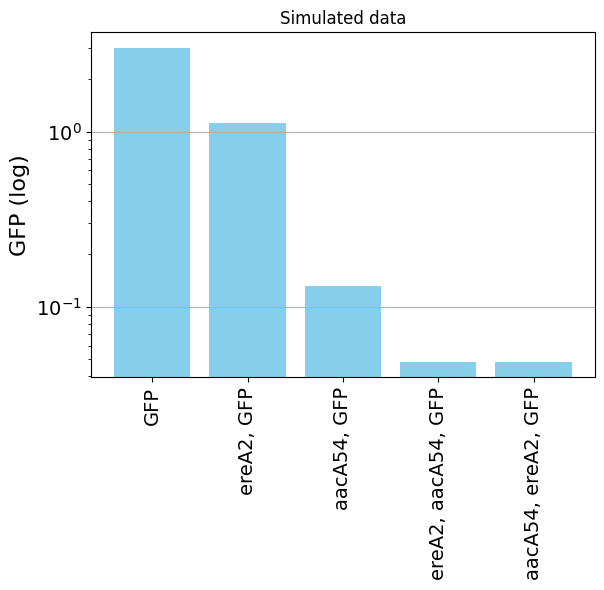

	Combination 111: Total protein concentration of X = 0
	Combination 112: Total protein concentration of X = 0
	Combination 11X: Total protein concentration of X = 0.005686244222159913
	Combination 110: Total protein concentration of X = 0
	Combination 121: Total protein concentration of X = 0
	Combination 122: Total protein concentration of X = 0
	Combination 12X: Total protein concentration of X = 0.04858409339034277
	Combination 120: Total protein concentration of X = 0
	Combination 1X1: Total protein concentration of X = 0.13060908340142735
	Combination 1X2: Total protein concentration of X = 0.130609083058174
	Combination 1XX: Total protein concentration of X = 0.22464762301160968
	Combination 1X0: Total protein concentration of X = 0.13060908314628908
	Combination 100: Total protein concentration of X = 0
	Combination 211: Total protein concentration of X = 0
	Combination 212: Total protein concentration of X = 0
	Combination 21X: Total protein concentration of X = 0.0485840933902

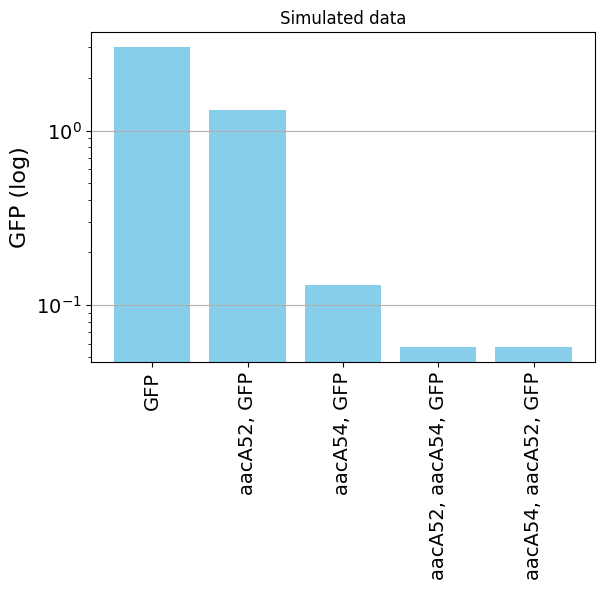

	Combination 111: Total protein concentration of X = 0
	Combination 112: Total protein concentration of X = 0
	Combination 11X: Total protein concentration of X = 0.005686244222159913
	Combination 110: Total protein concentration of X = 0
	Combination 121: Total protein concentration of X = 0
	Combination 122: Total protein concentration of X = 0
	Combination 12X: Total protein concentration of X = 0.05729154012766252
	Combination 120: Total protein concentration of X = 0
	Combination 1X1: Total protein concentration of X = 0.13060908340142735
	Combination 1X2: Total protein concentration of X = 0.13060908314625205
	Combination 1XX: Total protein concentration of X = 0.22464762301160968
	Combination 1X0: Total protein concentration of X = 0.13060908314628908
	Combination 100: Total protein concentration of X = 0
	Combination 211: Total protein concentration of X = 0
	Combination 212: Total protein concentration of X = 0
	Combination 21X: Total protein concentration of X = 0.05729154011

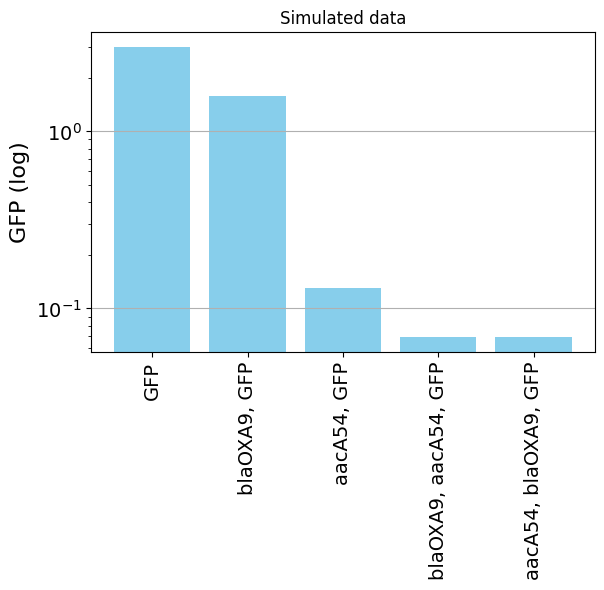

	Combination 111: Total protein concentration of X = 0
	Combination 112: Total protein concentration of X = 0
	Combination 11X: Total protein concentration of X = 0.005686244222159913
	Combination 110: Total protein concentration of X = 0
	Combination 121: Total protein concentration of X = 0
	Combination 122: Total protein concentration of X = 0
	Combination 12X: Total protein concentration of X = 0.06876706433886211
	Combination 120: Total protein concentration of X = 0
	Combination 1X1: Total protein concentration of X = 0.13060908340142735
	Combination 1X2: Total protein concentration of X = 0.13060908294313156
	Combination 1XX: Total protein concentration of X = 0.22464762301160968
	Combination 1X0: Total protein concentration of X = 0.13060908314628908
	Combination 100: Total protein concentration of X = 0
	Combination 211: Total protein concentration of X = 0
	Combination 212: Total protein concentration of X = 0
	Combination 21X: Total protein concentration of X = 0.06876706433

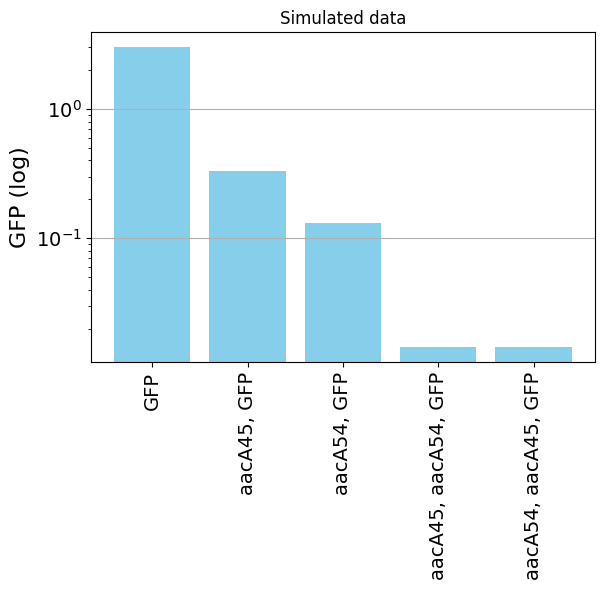

	Combination 111: Total protein concentration of X = 0
	Combination 112: Total protein concentration of X = 0
	Combination 11X: Total protein concentration of X = 0.005686244222159913
	Combination 110: Total protein concentration of X = 0
	Combination 121: Total protein concentration of X = 0
	Combination 122: Total protein concentration of X = 0
	Combination 12X: Total protein concentration of X = 0.014400922306795703
	Combination 120: Total protein concentration of X = 0
	Combination 1X1: Total protein concentration of X = 0.13060908340142735
	Combination 1X2: Total protein concentration of X = 0.1306090827542758
	Combination 1XX: Total protein concentration of X = 0.22464762301160968
	Combination 1X0: Total protein concentration of X = 0.13060908314628908
	Combination 100: Total protein concentration of X = 0
	Combination 211: Total protein concentration of X = 0
	Combination 212: Total protein concentration of X = 0
	Combination 21X: Total protein concentration of X = 0.01440092230

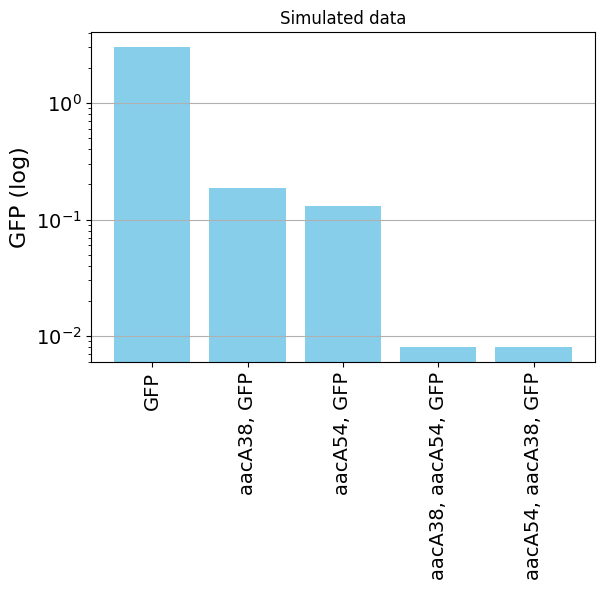

	Combination 111: Total protein concentration of X = 0
	Combination 112: Total protein concentration of X = 0
	Combination 11X: Total protein concentration of X = 0.005686244222159913
	Combination 110: Total protein concentration of X = 0
	Combination 121: Total protein concentration of X = 0
	Combination 122: Total protein concentration of X = 0
	Combination 12X: Total protein concentration of X = 0.008034850950348978
	Combination 120: Total protein concentration of X = 0
	Combination 1X1: Total protein concentration of X = 0.13060908340142735
	Combination 1X2: Total protein concentration of X = 0.13060908314825898
	Combination 1XX: Total protein concentration of X = 0.22464762301160968
	Combination 1X0: Total protein concentration of X = 0.13060908314628908
	Combination 100: Total protein concentration of X = 0
	Combination 211: Total protein concentration of X = 0
	Combination 212: Total protein concentration of X = 0
	Combination 21X: Total protein concentration of X = 0.0080348509

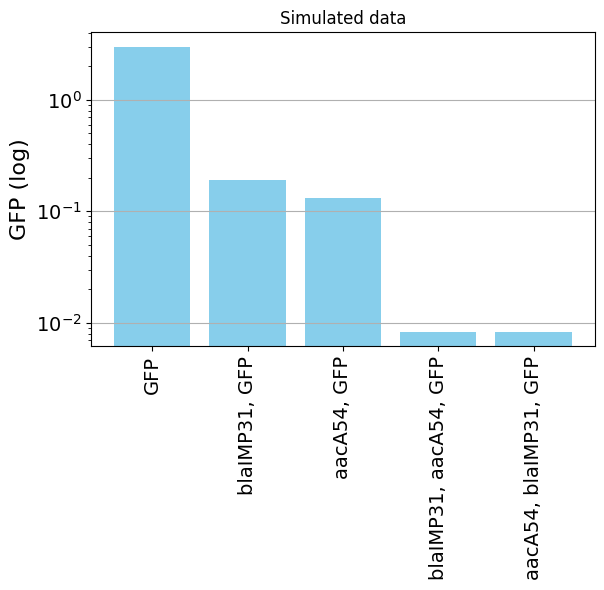

	Combination 111: Total protein concentration of X = 0
	Combination 112: Total protein concentration of X = 0
	Combination 11X: Total protein concentration of X = 0.005686244222159913
	Combination 110: Total protein concentration of X = 0
	Combination 121: Total protein concentration of X = 0
	Combination 122: Total protein concentration of X = 0
	Combination 12X: Total protein concentration of X = 0.008255910208841373
	Combination 120: Total protein concentration of X = 0
	Combination 1X1: Total protein concentration of X = 0.13060908340142735
	Combination 1X2: Total protein concentration of X = 0.13060908316312764
	Combination 1XX: Total protein concentration of X = 0.22464762301160968
	Combination 1X0: Total protein concentration of X = 0.13060908314628908
	Combination 100: Total protein concentration of X = 0
	Combination 211: Total protein concentration of X = 0
	Combination 212: Total protein concentration of X = 0
	Combination 21X: Total protein concentration of X = 0.0082559101

In [ ]:


# Iterate through each row in df_fluorescenceGC to get combinations of GC1 and GC2
for index, row in df_fluorescenceGC.iterrows():

    cassettes = [1, 2, 'X']  # 1, 2, and 'X' represent actual cassette types
    permutation_gene_labels = [row['GC1'], row['GC2'], row['GC3']]
    print("\nSimulating: ",permutation_gene_labels)

    permutations_list = {
        "[X]": [(2,)],
        "[1, X]": [(0, 2)],
        "[2, X]": [(1, 2)],
        "[2, 1, X]": [(1, 0, 2)],
        "[1, 2, X]": [(0, 1, 2)]
    }

    # Retrieve synthetic k_values for the selected genes
    test_k_values = [k_values_all[gene_labels.index(gene)] for gene in permutation_gene_labels]

    #Simulate and visualize 3 cassette permutations
    sim_values_dict = {
        "[X]": [run_experiment(perm, test_k_values) for perm in permutations_list["[X]"]],
        "[2, X]": [run_experiment(perm, test_k_values) for perm in permutations_list["[2, X]"]],
        "[1, X]": [run_experiment(perm, test_k_values) for perm in permutations_list["[1, X]"]],
        "[2, 1, X]": [run_experiment(perm, test_k_values) for perm in permutations_list["[2, 1, X]"]],
        "[1, 2, X]": [run_experiment(perm, test_k_values) for perm in permutations_list["[1, 2, X]"]]
    }

    ##permutations_gene_labels = ['aacA8', 'aacA54', 'GFP']  # Replace with actual gene labels
    plotExpressionPermutation(permutations_list, permutation_gene_labels, sim_values_dict)



    # Generate all possible combinations of three positions with optional empty slots at the end
    all_combinations = list(product(cassettes + [None], repeat=3))  # `None` represents an empty slot

    # Dictionary to store results for each combination
    values_dict = {}

    # Run the experiment for all combinations and store the results
    for comb in all_combinations:
        # Remove None values for running the experiment
        filtered_comb = [gene for gene in comb if gene is not None]
        values_dict[tuple(filtered_comb)] = run_experiment_permutations(filtered_comb, test_k_values)

    # Define a list to collect data for each combination
    data = []
    # Print the results for each combination with custom formatting
    for comb_label, result in values_dict.items():
        # Construct the formatted label, replacing None with '0' to represent empty slots
        formatted_label = ''.join([str(gene) if gene != 'X' else 'X' for gene in comb_label])
        formatted_label = formatted_label.ljust(3, '0')  # Pad with zeros to ensure 3 characters

        print(f"\tCombination {formatted_label}: Total protein concentration of X = {result}")

        # Append the label and result as a dictionary
        data.append({"Combination": formatted_label, "Total Protein Concentration of X": result})





    # Convert the list into a DataFrame
    df_results = pd.DataFrame(data)

    # Display the DataFrame
    #print(df_results)
    pathPARAMS = os.path.join(base_path, 'data/')
    dirNameData = os.path.join(pathPARAMS, f"X_{row['GC1']}_{row['GC2']}")
    os.makedirs(dirNameData, exist_ok=True)

    # Generate the file name based on the first two elements of test_gene_labels
    file_name = f"X_{row['GC1']}_{row['GC2']}.csv"

    # Define the full output path
    output_file = os.path.join(dirNameData, file_name)

    # Save the DataFrame to this dynamically generated file path
    df_results.to_csv(output_file, index=False)

    print(f"File saved to: {output_file}")


#High polarity: aaCA37-aacA45
#Low polarity: aaCA37-catB5


## Experimental data

In [ ]:

# Example usage
permutations_gene_labels = ['aacA8', 'aacA54', 'GFP']  # Replace with actual gene labels


# Defining the specific cases for the experiment
permutations_list = {
    "[3]": [(2,)],
    "[1, 3]": [(0, 2)],
    "[2, 3]": [(1, 2)],
    "[1, 2, 3]": [(0, 1, 2)],
    "[2, 1, 3]": [(1, 0, 2)]
}

In [ ]:

sheet = gc.open_by_url(sheet_url)

# Load the 'FluorescencePermutations' sheet with the first row as headers
worksheet_permutations = sheet.worksheet('FluorescencePermutations')
df_permutations = get_as_dataframe(worksheet_permutations, header=0)

# Display the loaded data to verify
print(df_permutations)


In [ ]:
# Initialize the dictionary to store GFP values for each permutation
data_values_dict = {}


# Defining the specific cases for the experiment
permutations_list = {
    "[3]": [(2,)],
    "[1, 3]": [(0, 2)],
    "[2, 3]": [(1, 2)],
    "[1, 2, 3]": [(0, 1, 2)],
    "[2, 1, 3]": [(1, 0, 2)]
}

# Iterate over each key in permutations_list and gather the corresponding GFP values
for perm_key, gene_order_list in permutations_list.items():
    # Collect GFP values for each permutation specified by `gene_order_list`
    gfp_values = []

    for gene_indices in gene_order_list:
        # Construct the gene labels for the current permutation order using `permutations_gene_labels`
        permutation_gene_labels = [permutations_gene_labels[i] for i in gene_indices]

        # Filter df_permutations for the current combination in permutation_gene_labels
        matching_row = df_permutations[
            (df_permutations['GC1'] == permutation_gene_labels[0]) &
            (df_permutations['GC2'] == permutation_gene_labels[1] if len(permutation_gene_labels) > 1 else True) &
            (df_permutations['GC3'] == permutation_gene_labels[2] if len(permutation_gene_labels) > 2 else True)
        ]

        # Extract GFP value if a matching row is found
        if not matching_row.empty:
            gfp_value = matching_row['GFP'].values[0]
            gfp_values.append(gfp_value)
        else:
            gfp_values.append(None)  # Append None if no match is found for consistency

    # Store the collected GFP values in data_values_dict under the current permutation key
    data_values_dict[perm_key] = gfp_values

# Display the populated data_values_dict
print("Populated data_values_dict:", data_values_dict)

# Plot using the plotExpressionComparison function with the populated data_values_dict
plotExpressionPermutation(permutations_list, permutations_gene_labels, data_values_dict, color='lightgreen')


### Simulation

In [ ]:


sim_values_dict = {
    "[3]": [run_experiment(perm, test_k_values) for perm in permutations_list["[3]"]],
    "[2, 3]": [run_experiment(perm, test_k_values) for perm in permutations_list["[2, 3]"]],
    "[1, 3]": [run_experiment(perm, test_k_values) for perm in permutations_list["[1, 3]"]],
    "[2, 1, 3]": [run_experiment(perm, test_k_values) for perm in permutations_list["[2, 1, 3]"]],
    "[1, 2, 3]": [run_experiment(perm, test_k_values) for perm in permutations_list["[1, 2, 3]"]]
}

# Plot the protein concentration of Gene X based on different gene orders
plotExpressionPermutation(permutations_list, permutation_gene_labels, sim_values_dict)
